In [3]:
# Import required libraries
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import and reload to get latest changes
from core.backtest_orchestrator import BacktestOrchestrator
from signals.momentum import MomentumSignalV2
from signals.mean_reversion import MeanReversionSignal

# Reload modules to get latest code changes
import importlib
import core.backtest_orchestrator
importlib.reload(core.backtest_orchestrator)
from core.backtest_orchestrator import BacktestOrchestrator

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 4)

print("✅ Imports successful (modules reloaded)")
print(f"   Project root: {project_root}")

✅ Imports successful (modules reloaded)
   Project root: /Users/Sakarias/QuantTrading


# Multi-Strategy Backtest Template

**Recent Updates:**
- ✅ Fixed MeanReversionSignal bug (forward-fill after exit was causing positions to persist)
- ✅ Made signal parameters more reactive (shorter lookbacks, tighter thresholds)
- ✅ Added risk manager logging to CSV files (`logs/risk_blocks_train.csv` and `logs/risk_blocks_oos.csv`)
- ✅ Risk logs capture: date, ticker, reason, portfolio value, attempted shares, and strategy details

## 1. Portfolio Configuration

Define portfolio-level settings. This CONFIG dictionary controls:
- **assets**: Which instruments to trade
- **total_capital**: Total portfolio capital (for capital_pct allocation)
- **oos_split**: Out-of-sample percentage (e.g., 0.20 = 80% train, 20% test)
- **date_range**: Backtest period
- **use_futures_sizing**: Whether to use integer contract sizing

In [4]:
# Portfolio Configuration
CONFIG = {
    'assets': ['ES', 'NQ'],  # S&P 500 and Nasdaq futures
    'total_capital': 500_000,  # $500k portfolio
    'oos_split': 0.20,  # 80% train, 20% out-of-sample
    'date_range': ('2015-01-01', '2024-12-31'),  # 10 years
    'use_futures_sizing': False  # Set True for futures contract sizing
}

print("📋 Portfolio Configuration:")
print(f"   Assets: {CONFIG['assets']}")
print(f"   Total Capital: ${CONFIG['total_capital']:,}")
print(f"   Train/Test Split: {(1-CONFIG['oos_split'])*100:.0f}% / {CONFIG['oos_split']*100:.0f}%")
print(f"   Date Range: {CONFIG['date_range'][0]} to {CONFIG['date_range'][1]}")

📋 Portfolio Configuration:
   Assets: ['ES', 'NQ']
   Total Capital: $500,000
   Train/Test Split: 80% / 20%
   Date Range: 2015-01-01 to 2024-12-31


**⚠️ Important Configuration Notes:**

- **total_capital**: Use realistic values ($100k-$1M for testing). Very large capitals ($100M+) can cause position sizing issues.
- **risk_per_trade**: Keep between 1-3% (0.01-0.03). Higher values lead to excessive position sizes.
- **Date range**: Ensure you have enough data for both train and test periods.

If you see **all metrics as 0** and **0 trades**, common causes are:
1. Capital set too high (e.g., $500M instead of $500k)
2. risk_per_trade too high (e.g., 6% instead of 2%)
3. Warmup period needs more data

## 2. Initialize Orchestrator & Load Data

Create the orchestrator with our config and load price data.

In [5]:
# Initialize orchestrator with config
orchestrator = BacktestOrchestrator(config=CONFIG)

# Load data for all assets
orchestrator.load_data(
    tickers=CONFIG['assets'],
    start_date=CONFIG['date_range'][0],
    end_date=CONFIG['date_range'][1],
    use_yfinance=True,
    verbose=True
)

# Optional: Load benchmark for comparison
orchestrator.load_benchmark('SPY', verbose=True)

📊 Loading data for 2 assets...

Loading 2 assets: ['ES', 'NQ']
  📡 CSV data is 341 days old, fetching recent data from yfinance...
  ✓ Added 235 days from yfinance (now through 2025-12-05)
✓ ES: 6369 rows, 2000-09-18 to 2025-12-05
  📡 CSV data is 341 days old, fetching recent data from yfinance...
  ✓ Added 235 days from yfinance (now through 2025-12-05)
✓ NQ: 6369 rows, 2000-09-18 to 2025-12-05

Common date range: 2000-09-18 to 2025-12-05
Filtered date range: 2015-01-01 to 2024-12-31

Total unique dates: 2515

ALIGNMENT SUMMARY
ES: 2515/2515 valid dates (100.0%)
NQ: 2515/2515 valid dates (100.0%)

✅ Data loaded successfully:
   ES: 2515 days (2015-01-02 to 2024-12-31)
      Price range: $1824.50 - $6099.00
   NQ: 2515 days (2015-01-02 to 2024-12-31)
      Price range: $3944.25 - $22110.25

📈 Loading benchmark: SPY...
📥 Updating SPY benchmark data...
  ✓ Added 235 days from yfinance (now through 2025-12-05)
✓ ES: 6369 rows, 2000-09-18 to 2025-12-05
  📡 CSV data is 341 days old, fetchin

## 3. Split Train/Test Data

Split data into in-sample (train) and out-of-sample (test) periods.
This is crucial for preventing overfitting!

The split uses the `oos_split` percentage from CONFIG.

In [6]:
# Split data: 80% train, 20% OOS
orchestrator.split_train_test_data(verbose=True)

print("\n📊 Data split complete!")
print(f"   In-sample: {len(orchestrator.prices_train['ES'])} days")
print(f"   Out-of-sample: {len(orchestrator.prices_test['ES'])} days")


📊 Splitting data: 80% train, 20% OOS
  ES: 2012 train days, 503 test days
      Train: 2015-01-02 to 2022-12-30
      Test:  2023-01-03 to 2024-12-31
  NQ: 2012 train days, 503 test days
      Train: 2015-01-02 to 2022-12-30
      Test:  2023-01-03 to 2024-12-31
✅ Data split complete. Use .prices for train, .prices_test for OOS

📊 Data split complete!
   In-sample: 2012 days
   Out-of-sample: 503 days


## 4. Define Strategies

Add strategies interactively with:
- **name**: Strategy identifier
- **signal_generator**: Signal class instance
- **assets**: Which assets this strategy trades
- **capital_pct**: Percentage of total_capital (auto-validates ≤ 100%)
- **position_sizer_type**: Sizing method ('fixed', 'atr', 'volatility', 'kelly', 'futures')
- **risk_per_trade**: Risk per trade (default: 0.02 = 2%)

### Available Position Sizers:
- **'fixed'**: Fixed fractional (risk-based)
- **'atr'**: ATR-based volatility sizing
- **'volatility'**: Inverse volatility weighting
- **'kelly'**: Kelly Criterion
- **'futures'**: Integer contract sizing

**⚠️ Important:** If you get an allocation error when rerunning this cell, you need to reinitialize the orchestrator (rerun cells 2-4) or clear the strategies first.

In [7]:
# Strategy 1: Momentum on ES (60% of capital)
# More reactive: shorter lookback (10 days) and lower threshold (1%)
orchestrator.add_strategy(
    name='Momentum_ES',
    signal_generator=MomentumSignalV2(lookback=10, entry_threshold=0.01),
    assets=['ES'],
    capital_pct=0.60,  # 60% = $300k
    position_sizer_type='fixed',
    risk_per_trade=0.02  # 2% risk per trade
)

# Strategy 2: Mean Reversion on NQ (40% of capital)
# More reactive: shorter window (20 days) and tighter z-scores (1.5 entry, 0.3 exit)
orchestrator.add_strategy(
    name='MeanReversion_NQ',
    signal_generator=MeanReversionSignal(window=20, entry_z=1.5, exit_z=0.3),
    assets=['NQ'],
    capital_pct=0.40,  # 40% = $200k
    position_sizer_type='fixed',
    risk_per_trade=0.02
)

print("\n✅ Strategies configured successfully!")
print(f"   Total allocated: {orchestrator.allocated_capital:.1%} of capital")


✅ Strategies configured successfully!
   Total allocated: 100.0% of capital


## 5. Generate Signals (In-Sample)

Generate trading signals on the training data.

In [8]:
# Generate signals for all strategies
orchestrator.generate_signals(verbose=True)


🎯 Generating signals for 2 strategies...

  Momentum_ES (MomentumSignalV2):
    ES: 94.0% long, 0.0% short, 6.0% flat

  MeanReversion_NQ (MeanReversionSignal):
    NQ: 24.3% long, 50.5% short, 25.2% flat

✅ Signals generated successfully


## 6. Run In-Sample Backtests

Execute backtests on the training period.

**Note:** Risk blocking logs will be saved to `logs/risk_blocks_train.csv` if any trades are rejected by the risk manager.

In [9]:
# Run backtests with risk logging
results = orchestrator.run_backtests(verbose=True)

# Check if any trades were blocked
import os
if os.path.exists('logs/risk_blocks_train.csv'):
    risk_log = pd.read_csv('logs/risk_blocks_train.csv')
    if len(risk_log) > 0:
        print(f"\n⚠️  {len(risk_log)} trades were blocked by risk manager")
        print(f"   See logs/risk_blocks_train.csv for details")
    else:
        print("\n✅ No trades blocked by risk manager")
else:
    print("\n✅ No trades blocked by risk manager")


🔄 Running backtests for 2 strategies...

  Momentum_ES ($300,000.0)...
    ✅ Total Return: 84.20%
    📊 Sharpe: 0.40
    📉 Max DD: -34.41%

  MeanReversion_NQ ($200,000.0)...
    ✅ Total Return: 38.21%
    📊 Sharpe: 0.21
    📉 Max DD: -24.88%

✅ All backtests completed successfully

✅ No trades blocked by risk manager


In [10]:
# Debug: Check why no trades are occurring
print("🔍 Diagnostics - Checking signal and trade data:\n")

for strategy in orchestrator.strategies:
    name = strategy.name
    asset = strategy.assets[0]
    
    print(f"📊 {name}:")
    print(f"   Capital: ${strategy.capital:,.0f}")
    print(f"   Max position %: {strategy.max_position_pct:.2%}")
    print(f"   Risk per trade: {strategy.risk_per_trade:.2%}")
    
    # Check signals
    if name in orchestrator.signals and asset in orchestrator.signals[name]:
        signals_df = orchestrator.signals[name][asset]
        print(f"   Signal data shape: {signals_df.shape}")
        print(f"   Signal column exists: {'Signal' in signals_df.columns}")
        print(f"   Non-zero signals: {(signals_df['Signal'] != 0).sum()}")
        print(f"   Sample signals (first 10):")
        print(f"      {signals_df['Signal'].head(10).tolist()}")
    
    # Check backtest result
    if name in orchestrator.results:
        result = orchestrator.results[name]['result']
        print(f"   Equity curve shape: {result.equity_curve.shape}")
        print(f"   Number of trades: {len(result.trades)}")
        print(f"   Final equity: ${result.equity_curve['TotalValue'].iloc[-1]:,.2f}")
        
        if len(result.trades) == 0:
            print(f"   ⚠️  NO TRADES EXECUTED - Possible issues:")
            print(f"      - Position sizing might be too aggressive")
            print(f"      - Capital might be too large")
            print(f"      - Check position sizer parameters")
    
    print()

🔍 Diagnostics - Checking signal and trade data:

📊 Momentum_ES:
   Capital: $300,000
   Max position %: 100.00%
   Risk per trade: 2.00%
   Signal data shape: (2012, 10)
   Signal column exists: True
   Non-zero signals: 1892
   Sample signals (first 10):
      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
   Equity curve shape: (2012, 4)
   Number of trades: 0
   Final equity: $552,591.17
   ⚠️  NO TRADES EXECUTED - Possible issues:
      - Position sizing might be too aggressive
      - Capital might be too large
      - Check position sizer parameters

📊 MeanReversion_NQ:
   Capital: $200,000
   Max position %: 100.00%
   Risk per trade: 2.00%
   Signal data shape: (2012, 8)
   Signal column exists: True
   Non-zero signals: 1504
   Sample signals (first 10):
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
   Equity curve shape: (2012, 4)
   Number of trades: 71
   Final equity: $276,416.62



In [11]:
# Deeper investigation: Check signal values and position sizing
print("🔬 Deep Dive: Signal Values and Position Sizing\n")

for strategy in orchestrator.strategies:
    name = strategy.name
    asset = strategy.assets[0]
    
    print(f"📊 {name} ({asset}):")
    
    # Get signals
    signals_df = orchestrator.signals[name][asset]
    
    # Show signal statistics
    print(f"\n   Signal Statistics:")
    print(f"   - Total rows: {len(signals_df)}")
    print(f"   - Long signals (1): {(signals_df['Signal'] == 1).sum()}")
    print(f"   - Short signals (-1): {(signals_df['Signal'] == -1).sum()}")
    print(f"   - Neutral signals (0): {(signals_df['Signal'] == 0).sum()}")
    
    # Show first non-zero signals
    non_zero = signals_df[signals_df['Signal'] != 0]
    if len(non_zero) > 0:
        print(f"\n   First 5 non-zero signals:")
        print(non_zero[['Signal']].head().to_string())
    else:
        print(f"\n   ⚠️  No non-zero signals found!")
    
    # Check if there's a position size column
    if 'PositionSize' in signals_df.columns:
        print(f"\n   Position Size Statistics:")
        print(f"   - Non-zero positions: {(signals_df['PositionSize'] != 0).sum()}")
        print(f"   - Max position size: {signals_df['PositionSize'].max()}")
        print(f"   - Min position size: {signals_df['PositionSize'].min()}")
    
    # Check backtest result trades
    result = orchestrator.results[name]['result']
    print(f"\n   Backtest Result:")
    print(f"   - Trades list length: {len(result.trades)}")
    print(f"   - Trades list type: {type(result.trades)}")
    if hasattr(result, 'positions'):
        print(f"   - Positions: {result.positions}")
    
    print("\n" + "-"*80 + "\n")

🔬 Deep Dive: Signal Values and Position Sizing

📊 Momentum_ES (ES):

   Signal Statistics:
   - Total rows: 2012
   - Long signals (1): 1892
   - Short signals (-1): 0
   - Neutral signals (0): 120

   First 5 non-zero signals:
            Signal
Date              
2015-06-25     1.0
2015-06-26     1.0
2015-06-29     1.0
2015-06-30     1.0
2015-07-01     1.0

   Backtest Result:
   - Trades list length: 0
   - Trades list type: <class 'pandas.core.frame.DataFrame'>

--------------------------------------------------------------------------------

📊 MeanReversion_NQ (NQ):

   Signal Statistics:
   - Total rows: 2012
   - Long signals (1): 488
   - Short signals (-1): 1016
   - Neutral signals (0): 508

   First 5 non-zero signals:
            Signal
Date              
2015-02-10      -1
2015-02-11      -1
2015-02-12      -1
2015-02-13      -1
2015-02-17      -1

   Backtest Result:
   - Trades list length: 71
   - Trades list type: <class 'pandas.core.frame.DataFrame'>

----------------

In [12]:
# Check: Are we looking at OOS signals or In-Sample signals?
print("📅 Data Period Check:\n")

for strategy in orchestrator.strategies:
    name = strategy.name
    asset = strategy.assets[0]
    
    signals_df = orchestrator.signals[name][asset]
    
    print(f"{name}:")
    print(f"   Signal dates: {signals_df.index[0]} to {signals_df.index[-1]}")
    print(f"   Number of rows: {len(signals_df)}")
    print()

# Check the actual in-sample results
print("\n" + "="*80)
print("IN-SAMPLE RESULTS (Training Period):")
print("="*80)

for name in orchestrator.results.keys():
    result = orchestrator.results[name]['result']
    print(f"\n{name}:")
    print(f"   Date range: {result.equity_curve.index[0]} to {result.equity_curve.index[-1]}")
    print(f"   Days: {len(result.equity_curve)}")
    print(f"   Trades: {len(result.trades)}")
    print(f"   Return: {result.total_return:.2%}")
    
    # Show first few trades if any
    if len(result.trades) > 0:
        print(f"\n   First 3 trades:")
        print(result.trades.head(3)[['EntryDate', 'ExitDate', 'Side', 'PnL']].to_string(index=False))
    else:
        print(f"   ⚠️  NO TRADES IN TRAINING PERIOD")

📅 Data Period Check:

Momentum_ES:
   Signal dates: 2015-01-02 00:00:00 to 2022-12-30 00:00:00
   Number of rows: 2012

MeanReversion_NQ:
   Signal dates: 2015-01-02 00:00:00 to 2022-12-30 00:00:00
   Number of rows: 2012


IN-SAMPLE RESULTS (Training Period):

Momentum_ES:
   Date range: 2015-01-02 00:00:00 to 2022-12-30 00:00:00
   Days: 2012
   Trades: 0
   Return: 84.20%
   ⚠️  NO TRADES IN TRAINING PERIOD

MeanReversion_NQ:
   Date range: 2015-01-02 00:00:00 to 2022-12-30 00:00:00
   Days: 2012
   Trades: 71
   Return: 38.21%

   First 3 trades:


KeyError: "None of [Index(['EntryDate', 'ExitDate', 'Side', 'PnL'], dtype='object')] are in the [columns]"

In [ ]:
# Check if there are OPEN positions at the end of the backtest
print("🔎 Checking for Open Positions:\n")

for name in orchestrator.results.keys():
    result = orchestrator.results[name]['result']
    
    print(f"{name}:")
    print(f"   Closed trades: {len(result.trades)}")
    
    # Check if the portfolio manager or result has open positions
    if hasattr(result, 'final_positions'):
        print(f"   Open positions at end: {result.final_positions}")
    
    # Check equity curve - did it change?
    eq = result.equity_curve
    initial_value = eq['TotalValue'].iloc[0]
    final_value = eq['TotalValue'].iloc[-1]
    cash_at_end = eq['Cash'].iloc[-1] if 'Cash' in eq.columns else None
    
    print(f"   Initial value: ${initial_value:,.2f}")
    print(f"   Final value: ${final_value:,.2f}")
    if cash_at_end is not None:
        print(f"   Cash at end: ${cash_at_end:,.2f}")
        print(f"   Invested at end: ${final_value - cash_at_end:,.2f}")
    print(f"   Return: {(final_value/initial_value - 1):.2%}")
    print()

In [13]:
# Check signal TRANSITIONS (not just non-zero signals)
print("🔄 Signal Transition Analysis:\n")

# Look at in-sample results
for strategy in orchestrator.strategies:
    name = strategy.name
    asset = strategy.assets[0]
    
    # Get the TRAINING signals
    result = orchestrator.results[name]['result']
    
    # The signals should be stored in the result or we need to regenerate them
    # Let's use the current signals (which are OOS) as a proxy for analysis
    signals_df = orchestrator.signals[name][asset]
    
    print(f"{name} ({asset}):")
    print(f"   Total signal rows: {len(signals_df)}")
    
    # Count signal transitions
    signal_changes = signals_df['Signal'].diff().fillna(0)
    transitions = (signal_changes != 0).sum()
    
    # Entry transitions (0 → 1 or 0 → -1)
    entries = ((signals_df['Signal'].shift(1) == 0) & (signals_df['Signal'] != 0)).sum()
    
    # Exit transitions (±1 → 0)
    exits = ((signals_df['Signal'].shift(1) != 0) & (signals_df['Signal'] == 0)).sum()
    
    # Reversal transitions (+1 → -1 or -1 → +1)
    reversals = (signal_changes.abs() == 2).sum()
    
    print(f"   Total transitions: {transitions}")
    print(f"   Entry transitions (0→±1): {entries}")
    print(f"   Exit transitions (±1→0): {exits}")
    print(f"   Reversal transitions (1→-1 or -1→1): {reversals}")
    print(f"\n   Signal value distribution:")
    print(f"      {signals_df['Signal'].value_counts().to_dict()}")
    print()

🔄 Signal Transition Analysis:

Momentum_ES (ES):
   Total signal rows: 2012
   Total transitions: 1
   Entry transitions (0→±1): 1
   Exit transitions (±1→0): 1
   Reversal transitions (1→-1 or -1→1): 0

   Signal value distribution:
      {1.0: 1892, 0.0: 120}

MeanReversion_NQ (NQ):
   Total signal rows: 2012
   Total transitions: 304
   Entry transitions (0→±1): 152
   Exit transitions (±1→0): 152
   Reversal transitions (1→-1 or -1→1): 1

   Signal value distribution:
      {-1: 1016, 0: 508, 1: 488}



## 7. In-Sample Results

View detailed results for the training period.

In [14]:
# Print formatted summary
orchestrator.print_summary()


📊 BACKTEST SUMMARY
        Strategy   Capital Assets  Final Value  Total Return  CAGR  Sharpe  Max Drawdown  Win Rate  Total Trades
     Momentum_ES 300000.00     ES    552591.17          0.84  0.08    0.40         -0.34      0.00             0
MeanReversion_NQ 200000.00     NQ    276416.62          0.38  0.04    0.21         -0.25      0.76            71

----------------------------------------------------------------------------------------------------
Portfolio Total Capital: $500,000
Portfolio Final Value:   $829,008
Portfolio Return:        65.80%


In [15]:
# Get summary DataFrame for further analysis
summary_df = orchestrator.get_summary()
print("\n📊 Detailed Metrics:")
print(summary_df.to_string(index=False))


📊 Detailed Metrics:
        Strategy   Capital Assets  Final Value  Total Return  CAGR  Sharpe  Max Drawdown  Win Rate  Total Trades
     Momentum_ES 300000.00     ES    552591.17          0.84  0.08    0.40         -0.34      0.00             0
MeanReversion_NQ 200000.00     NQ    276416.62          0.38  0.04    0.21         -0.25      0.76            71


## 8. Visualize In-Sample Performance

Plot equity curves and benchmark comparison.

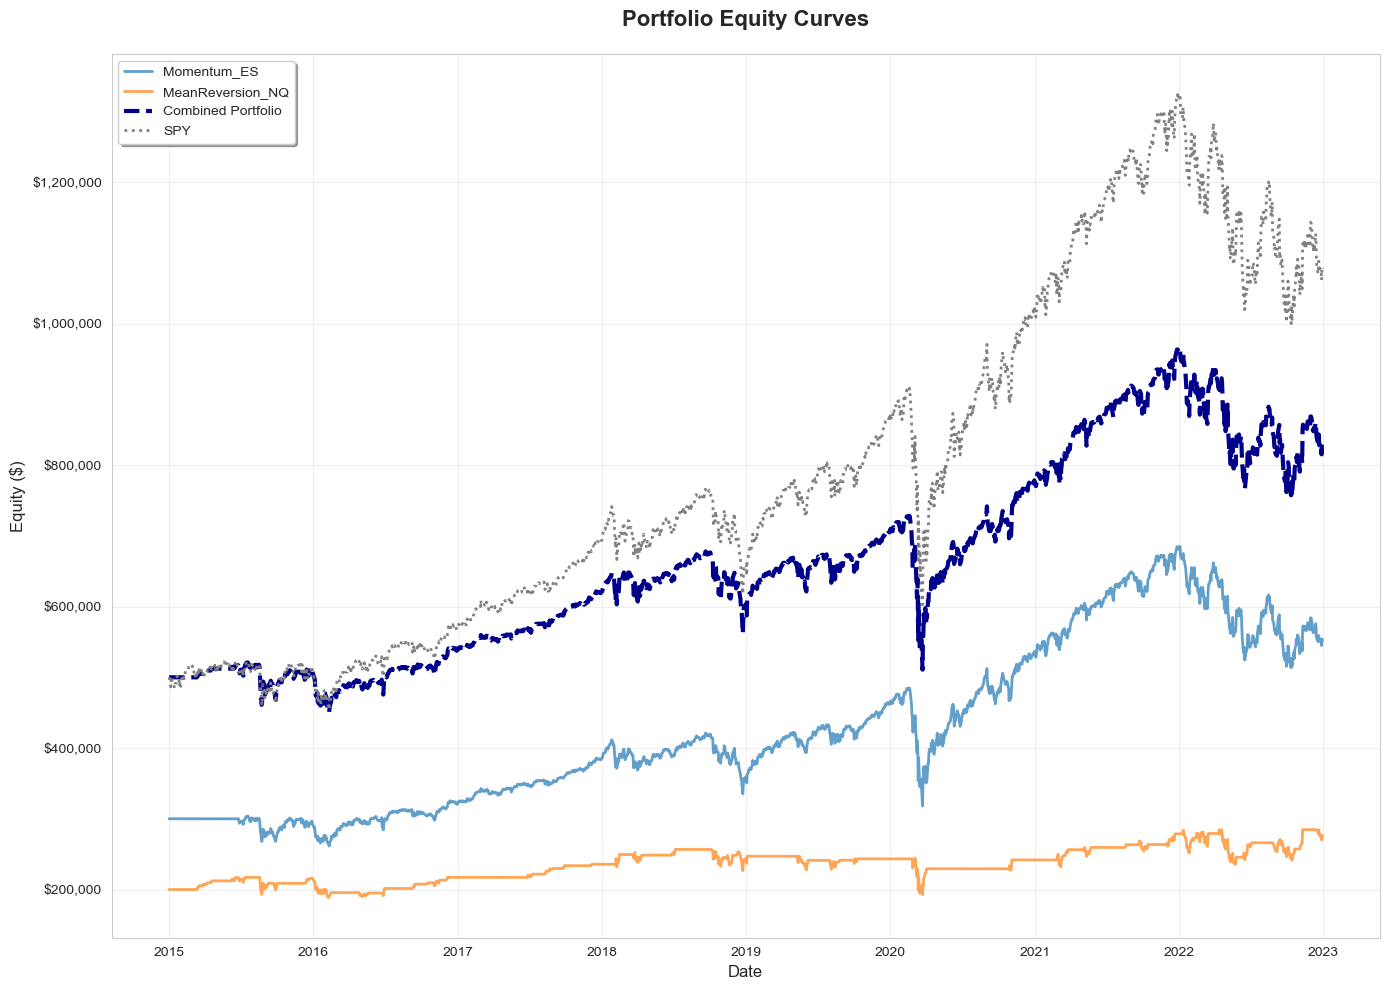

In [16]:
# Plot equity curves
orchestrator.plot_results(
    show_individual=True,
    show_benchmark=True,
    figsize=(14, 10)
)
plt.show()

## 9. Out-of-Sample Validation 🎯

Now test on the held-out OOS data to validate the strategy.
This is the TRUE test of whether the strategy will work in live trading!

**Note:** Risk blocking logs will be saved to `logs/risk_blocks_oos.csv` if any trades are rejected.

In [17]:
# Run OOS backtest with risk logging
oos_results = orchestrator.run_oos_backtest(verbose=True)

# Check if any trades were blocked in OOS
if os.path.exists('logs/risk_blocks_oos.csv'):
    risk_log_oos = pd.read_csv('logs/risk_blocks_oos.csv')
    if len(risk_log_oos) > 0:
        print(f"\n⚠️  {len(risk_log_oos)} trades were blocked by risk manager in OOS")
        print(f"   See logs/risk_blocks_oos.csv for details")
    else:
        print("\n✅ No trades blocked by risk manager in OOS")
else:
    print("\n✅ No trades blocked by risk manager in OOS")

print("\n" + "="*80)
print("📊 OUT-OF-SAMPLE COMPARISON")
print("="*80)

# Compare In-Sample vs OOS
for name in orchestrator.results.keys():
    is_result = orchestrator.results[name]['result']
    oos_result = orchestrator.oos_results[name]['result']
    
    print(f"\n{name}:")
    print(f"   In-Sample Return:  {is_result.total_return:>8.2%}")
    print(f"   OOS Return:        {oos_result.total_return:>8.2%}")
    print(f"   ")
    print(f"   In-Sample Sharpe:  {is_result.metrics['Sharpe Ratio']:>8.2f}")
    print(f"   OOS Sharpe:        {oos_result.metrics['Sharpe Ratio']:>8.2f}")
    print(f"   ")
    print(f"   In-Sample Max DD:  {is_result.metrics['Max Drawdown']:>8.2%}")
    print(f"   OOS Max DD:        {oos_result.metrics['Max Drawdown']:>8.2%}")

print("\n" + "="*80)


🎯 Running OUT-OF-SAMPLE backtests...

  Momentum_ES - Generating OOS signals...

  MeanReversion_NQ - Generating OOS signals...

  Momentum_ES ($300,000.0)...
    ✅ OOS Return: 33.85%
    📊 OOS Sharpe: 1.20
    📉 OOS Max DD: -10.20%

  MeanReversion_NQ ($200,000.0)...
    ✅ OOS Return: 23.27%
    📊 OOS Sharpe: 1.00
    📉 OOS Max DD: -7.81%

✅ OOS backtests completed

✅ No trades blocked by risk manager in OOS

📊 OUT-OF-SAMPLE COMPARISON

Momentum_ES:
   In-Sample Return:    84.20%
   OOS Return:          33.85%
   
   In-Sample Sharpe:      0.40
   OOS Sharpe:            1.20
   
   In-Sample Max DD:   -34.41%
   OOS Max DD:         -10.20%

MeanReversion_NQ:
   In-Sample Return:    38.21%
   OOS Return:          23.27%
   
   In-Sample Sharpe:      0.21
   OOS Sharpe:            1.00
   
   In-Sample Max DD:   -24.88%
   OOS Max DD:          -7.81%



## 10. Export Comprehensive HTML Reports

Generate professional HTML reports with **all visualizations** using the built-in comprehensive reporting method.

This generates three types of reports:
- 📈 **Multi-Strategy Report**: All equity curves, benchmark comparison, performance tables
- ⚠️ **Risk Dashboard**: VaR, CVaR, drawdowns, correlations, rolling metrics
- 📊 **Individual Strategy Reports**: Detailed analysis with Plotly interactive charts

**Note:** If you get `AttributeError: 'BacktestOrchestrator' object has no attribute 'generate_comprehensive_reports'`, 
rerun cell 1 (imports) and then cells 5-6 (initialize orchestrator and load data) to reload the updated class.

In [18]:
# Generate comprehensive HTML reports with one simple method call
report_paths = orchestrator.generate_comprehensive_reports(
    output_dir='results/html',
    benchmark_name='SPY',  # Optional: override benchmark display name
    title='Multi-Strategy Backtest Report',  # Optional: custom title
    auto_open=False  # Automatically opens main report in browser
)

# The method returns paths to all generated reports
print(f"\n📁 Report files:")
print(f"   Multi-Strategy: {report_paths['multi_strategy']}")
print(f"   Risk Dashboard: {report_paths['risk_dashboard']}")
print(f"   Individual Reports:")
for strategy_name, path in report_paths['individual'].items():
    print(f"      - {strategy_name}: {path}")

📊 Generating comprehensive HTML reports...

📊 Data alignment:
   Strategy period: 2015-01-02 to 2022-12-30
   Portfolio initial capital: $500,000
   Combined equity: 2012 days

1️⃣  Generating Multi-Strategy Report...
🔍 DEBUG _generate_main_chart called with 2 strategies
  Momentum_ES: 300000.00 → 552591.17
  MeanReversion_NQ: 200000.00 → 276416.62
🔍 DEBUG Figure has 4 traces:
  Trace 0 (Momentum_ES): y[0]=300000.00, y[-1]=552591.17, len=2012
  Trace 1 (MeanReversion_NQ): y[0]=200000.00, y[-1]=276416.62, len=2012
  Trace 2 (Combined Portfolio): y[0]=500000.00, y[-1]=829007.79, len=2012
  Trace 3 (SPY): y[0]=500000.00, y[-1]=1077488.52, len=2014
   ✅ Saved: results/html/multi_strategy_report_2025-12-07.html

2️⃣  Generating Risk Dashboard...
🔍 DEBUG Figure has 4 traces:
  Trace 0 (Momentum_ES): y[0]=300000.00, y[-1]=552591.17, len=2012
  Trace 1 (MeanReversion_NQ): y[0]=200000.00, y[-1]=276416.62, len=2012
  Trace 2 (Combined Portfolio): y[0]=500000.00, y[-1]=829007.79, len=2012
  Trace

## 11. Key Takeaways & Next Steps

### Interpretation Guidelines:

**Good Signs:**
- ✅ OOS performance within 70-80% of in-sample
- ✅ Positive Sharpe ratio in both periods
- ✅ Consistent drawdown patterns
- ✅ Similar trade frequency

**Red Flags:**
- ⚠️ OOS much worse than in-sample → Overfitting
- ⚠️ Negative OOS returns → Strategy doesn't work
- ⚠️ Dramatically different metrics → Unstable strategy

### Next Steps:

1. **If OOS looks good:** Consider walk-forward optimization to test across multiple periods
2. **If OOS is weak:** Adjust parameters, try different signals, or simplify strategy
3. **Before going live:** Test on more recent data, check for regime changes
4. **Paper trading:** Always paper trade before risking real capital!

### Advanced Analysis:

- Try different position sizers ('atr', 'volatility', 'kelly')
- Adjust capital allocation percentages
- Test on different assets
- Run walk-forward validation (see `template_walkforward.ipynb`)

## Additional Notes

This template demonstrates:
- ✅ Config-based portfolio setup
- ✅ Percentage-based capital allocation
- ✅ Multiple strategies on different assets
- ✅ In-sample training
- ✅ Out-of-sample validation
- ✅ Automated HTML export

